# EEG Preprocessing

#### _This is a template that will be parameterised and run via [Papermill](http://papermill.readthedocs.io/) for each subject_

This notebook performs preprocessing of localiser and task data. 

Preprocessing steps:

1. Identification and loading of raw data
2. Maxwell filtering
3. Filtering
4. Epoching
5. Downsampling
6. ICA


## Imports

In [1]:
import os
os.chdir('..')

from mne.io import read_raw_brainvision
import mne
import matplotlib.pyplot as plt
from mne.preprocessing import ICA, create_eog_epochs
import numpy as np
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import os
import time
import datetime
import yaml
import papermill as pm
import pandas as pd

%matplotlib inline

np.random.seed(100)

In [2]:
from mne.io import read_raw_brainvision

1. resample 
2. load channel locations/look them up based on standard templates
3. filter the data (I use 0.5 Hz and 45 Hz cutoffs, but depends what you are interested in and what type of filter in built in in that toolbox)
4. re-reference to the average of all channels and bring FCz back in (#1 could also be done here if you like instead, doesn't make much difference) if you do have very noisy channels, they need to be removed before 4 otherwise the average will be altered by these extreme data points and you can then interpolate them after
5. artefact rejection
6. ICA 

## Parameters

In [31]:
data_dir = '../EEG_decoding/data/'  # Directory containing data
session_id = 'e003'  # ID of the scanning session
n_runs = 9  # Number of runs
output_dir = 'data/derivatives'  # Where the output data should go
eye_tracking = True  # If True, eye-tracking measures will be used for exclusion of blink-related ICA components
n_stim = 7  # Number of stimuli
cores = 1  # Number of cores to use for parallel processing
blink_components = None

os.environ['OMP_NUM_THREADS'] = str(cores)

## Get data

Data is stored in [BIDS format](https://www.nature.com/articles/sdata2018110) - currently MNE doesn't directly read from BIDS however.

In [32]:
# Set the data directory for this subject
# data_dir = 'data/'
data_dir = os.path.join(data_dir, 'sub-{0}'.format(session_id), 'ses-01', 'eeg')

# Find all files in the directory and make sure they're in the right order (i.e. ascending)
data = os.listdir(data_dir)
data = sorted([i for i in data if '.vhdr' in i and str(session_id) in i])

# Check we have the right number of runs
# assert len(data) == n_runs, "Wrong number of data files, found {0}".format(len(data))

# See what has been found
print(data)

# Get all the data and read it in
raws = []
run_idx = range(0, n_runs)

# Read in each data set
for i in run_idx:
    start_time = time.time()
    raws.append(read_raw_brainvision(os.path.join(data_dir, data[i]), preload=True))
    time_taken = time.time() - start_time
    print("Time taken = {0}".format(str(datetime.timedelta(seconds=time_taken))))

# Concatenate the runs
raw = mne.concatenate_raws(raws)
del raws  # delete the list of raw data to conserve memory

# Label eye-tracking channels as EOG
# raw.set_channel_types({'UADC001-2910': 'eog', 'UADC002-2901': 'eog', 'UADC003-2901': 'eog'})

['e003b1.vhdr', 'e003b2.vhdr', 'e003b3.vhdr', 'e003b4.vhdr', 'e003b5.vhdr', 'e003b6.vhdr', 'e003b7.vhdr', 'e003b8.vhdr', 'e003b9.vhdr']


<ipython-input-32-949389cb721a>:22: DeprecationWarning:

stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning



Extracting parameters from ../EEG_decoding/data/sub-e003\ses-01\eeg\e003b1.vhdr...
Setting channel info structure...
Reading 0 ... 277359  =      0.000 ...   277.359 secs...
Used Annotations descriptions: ['Stimulus/S  1', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  7', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  6']
Time taken = 0:00:00.740203


<ipython-input-32-949389cb721a>:22: DeprecationWarning:

stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning



Extracting parameters from ../EEG_decoding/data/sub-e003\ses-01\eeg\e003b2.vhdr...
Setting channel info structure...
Reading 0 ... 280579  =      0.000 ...   280.579 secs...
Used Annotations descriptions: ['Stimulus/S  6', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  7', 'Stimulus/S  5', 'Stimulus/S  1', 'Stimulus/S  4']
Time taken = 0:00:00.827934


<ipython-input-32-949389cb721a>:22: DeprecationWarning:

stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning



Extracting parameters from ../EEG_decoding/data/sub-e003\ses-01\eeg\e003b3.vhdr...
Setting channel info structure...
Reading 0 ... 109319  =      0.000 ...   109.319 secs...
Used Annotations descriptions: ['Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  3', 'Stimulus/S  7', 'Stimulus/S  1', 'Stimulus/S  2', 'Stimulus/S  6']
Time taken = 0:00:00.390534


<ipython-input-32-949389cb721a>:22: DeprecationWarning:

stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning



Extracting parameters from ../EEG_decoding/data/sub-e003\ses-01\eeg\e003b4.vhdr...
Setting channel info structure...
Reading 0 ... 296799  =      0.000 ...   296.799 secs...
Used Annotations descriptions: ['Stimulus/S  1', 'Stimulus/S  4', 'Stimulus/S  5', 'Stimulus/S  7', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  6']
Time taken = 0:00:01.164598


<ipython-input-32-949389cb721a>:22: DeprecationWarning:

stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning



Extracting parameters from ../EEG_decoding/data/sub-e003\ses-01\eeg\e003b5.vhdr...
Setting channel info structure...
Reading 0 ... 451079  =      0.000 ...   451.079 secs...
Used Annotations descriptions: ['Stimulus/S  2', 'Stimulus/S 25', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S  4', 'Stimulus/S  1', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S  3']
Time taken = 0:00:01.171608


<ipython-input-32-949389cb721a>:22: DeprecationWarning:

stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning



Extracting parameters from ../EEG_decoding/data/sub-e003\ses-01\eeg\e003b6.vhdr...
Setting channel info structure...
Reading 0 ... 438839  =      0.000 ...   438.839 secs...
Used Annotations descriptions: ['Stimulus/S  2', 'Stimulus/S 25', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S  4']
Time taken = 0:00:01.155982


<ipython-input-32-949389cb721a>:22: DeprecationWarning:

stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning



Extracting parameters from ../EEG_decoding/data/sub-e003\ses-01\eeg\e003b7.vhdr...
Setting channel info structure...
Reading 0 ... 453979  =      0.000 ...   453.979 secs...
Used Annotations descriptions: ['Stimulus/S  2', 'Stimulus/S 25', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S  4', 'Stimulus/S  1', 'Stimulus/S  3', 'Stimulus/S 20', 'Stimulus/S 21']
Time taken = 0:00:01.390306


<ipython-input-32-949389cb721a>:22: DeprecationWarning:

stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning



Extracting parameters from ../EEG_decoding/data/sub-e003\ses-01\eeg\e003b8.vhdr...
Setting channel info structure...
Reading 0 ... 467499  =      0.000 ...   467.499 secs...
Used Annotations descriptions: ['Stimulus/S  2', 'Stimulus/S 25', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8', 'Stimulus/S  4', 'Stimulus/S  1', 'Stimulus/S  3', 'Stimulus/S 20', 'Stimulus/S 21']
Time taken = 0:00:01.610407


<ipython-input-32-949389cb721a>:22: DeprecationWarning:

stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning



Extracting parameters from ../EEG_decoding/data/sub-e003\ses-01\eeg\e003b9.vhdr...
Setting channel info structure...
Reading 0 ... 471239  =      0.000 ...   471.239 secs...
Used Annotations descriptions: ['Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S  4', 'Stimulus/S  1', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S 25', 'Stimulus/S  5', 'Stimulus/S  6', 'Stimulus/S  7', 'Stimulus/S  8']
Time taken = 0:00:01.383964


<ipython-input-32-949389cb721a>:27: RuntimeWarning:

Omitted 702 annotation(s) that were outside data range.



In [33]:
# raw.plot_psd(area_mode='range', tmax=10000, show=False, average=False, fmax=80);

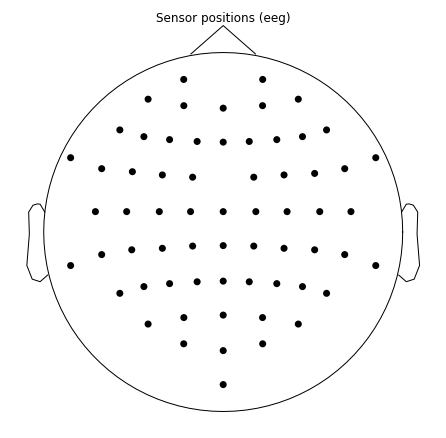

In [34]:
raw.plot_sensors();

## Preprocessing

### Plot the raw data

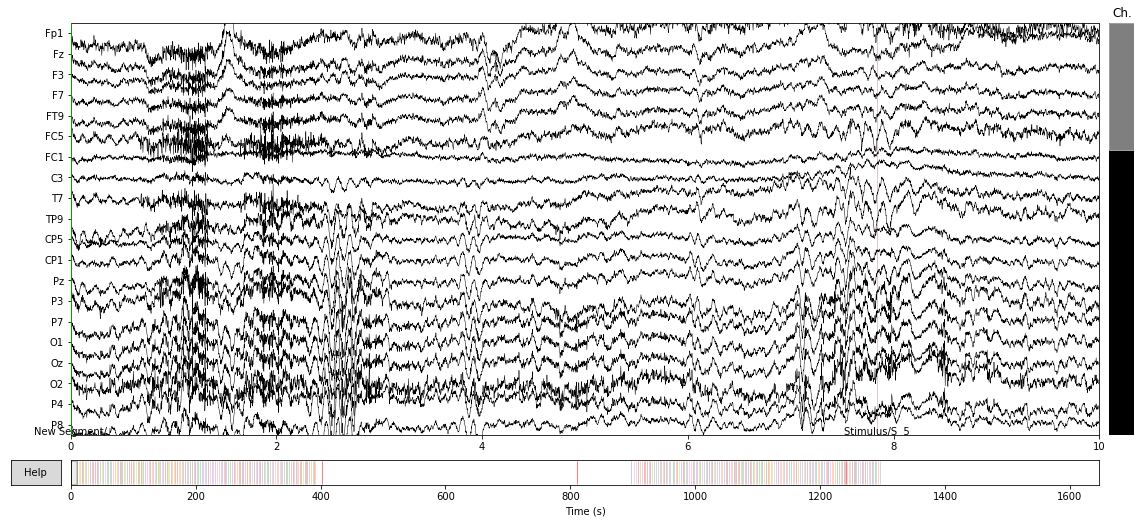

In [18]:
raw.plot();

### Filter

High pass filter above 0.5hz.

FILTERING
Setting up band-pass filter from 0.5 - 45 Hz
Setting up band-pass filter from 0.5 - 45 Hz
Setting up band-pass filter from 0.5 - 45 Hz
Setting up band-pass filter from 0.5 - 45 Hz
Setting up band-pass filter from 0.5 - 45 Hz
Setting up band-pass filter from 0.5 - 45 Hz
Setting up band-pass filter from 0.5 - 45 Hz
Setting up band-pass filter from 0.5 - 45 Hz
Setting up band-pass filter from 0.5 - 45 Hz


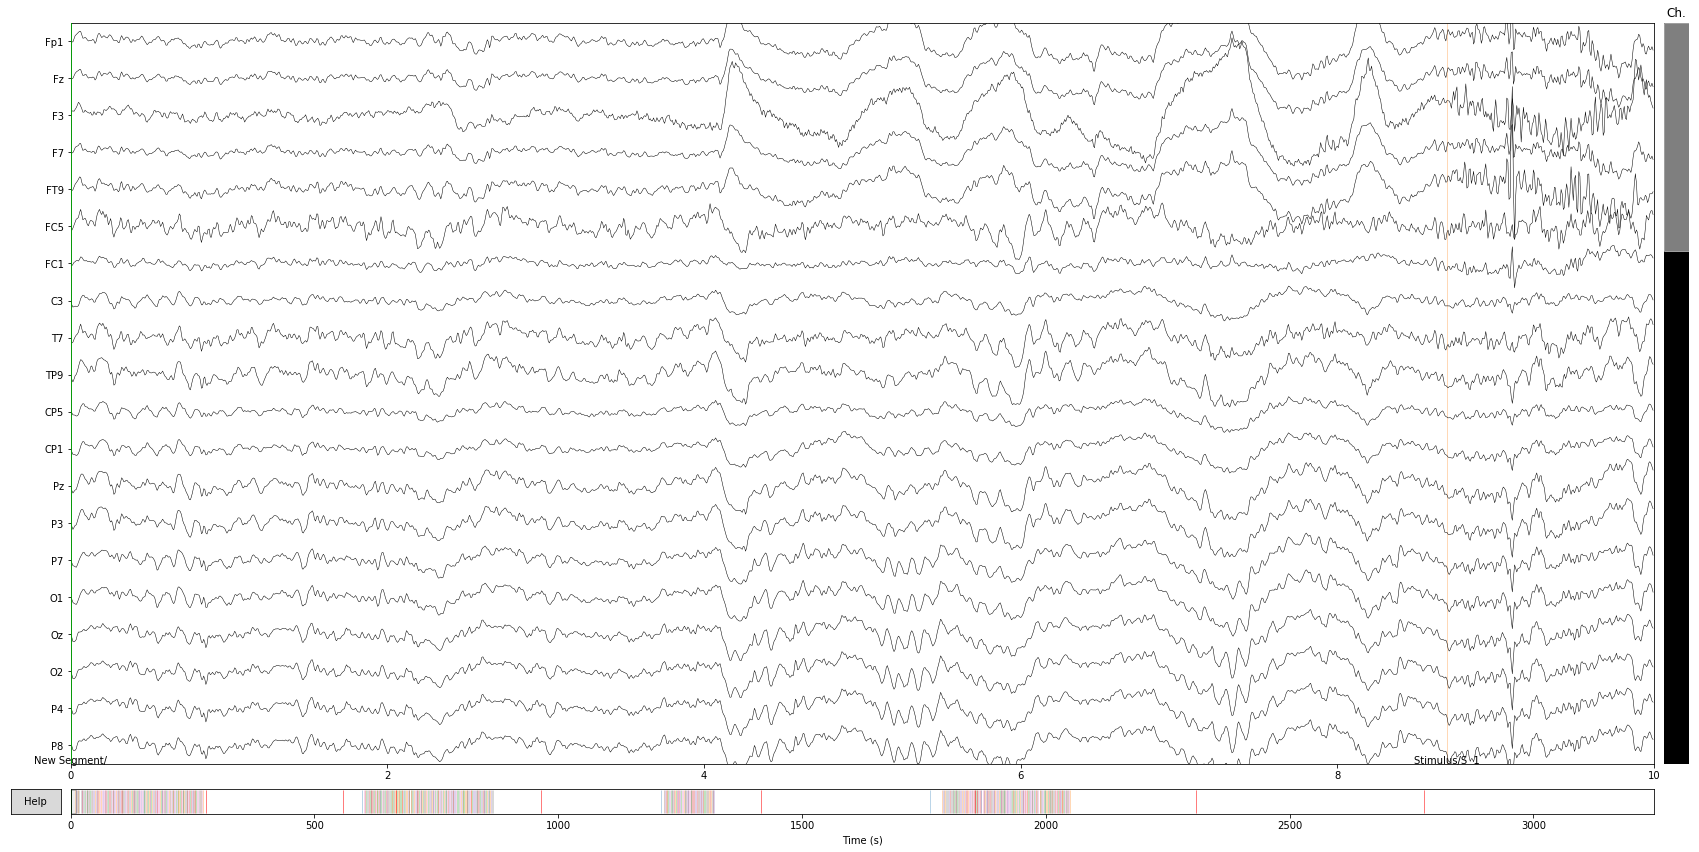

In [35]:
print("FILTERING")
raw.filter(0.5, 45, method='iir')
raw.plot();

In [36]:
raw = mne.add_reference_channels(raw, 'FCz')
montage = mne.channels.read_montage('standard_1020')
raw.set_montage(montage)
raw.del_proj()
raw, _ = mne.set_eeg_reference(raw, 'average', projection=False)

<ipython-input-36-26f034456872>:1: RuntimeWarning:

The locations of multiple reference channels are ignored (set to zero).



Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.


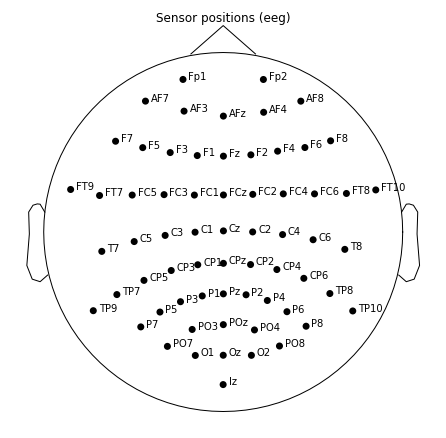

In [37]:
raw.plot_sensors(show_names=True);

## ICA

First we select bad data and channels

In [45]:
%matplotlib qt
raw.plot(n_channels=65, duration=300);

In [97]:
raw.info['bads']

['F5', 'FT8', 'TP7', 'F3']

In [56]:
annot_onsets = [0, 275, 550, 671, 1413, 2017, 2299, 3230]
annot_durations = [12, 12, 5, 25, 7, 13, 11, 500]
annot_names = ['bad'] * len(annot_onsets)
annotations = mne.Annotations(annot_onsets, annot_durations, annot_names)
raw.set_annotations(annotations)

<ipython-input-56-9cbbdba86fba>:5: RuntimeWarning:

Limited 1 annotation(s) that were expanding outside the data range.



<RawBrainVision  |  e003b1.eeg, n_channels x n_times : 66 x 3246700 (3246.7 sec), ~1.60 GB, data loaded>

## Run ICA

In [65]:
ica = ICA(method='infomax', n_components=0.95,
          random_state=0, max_iter=100).fit(raw, decim=20, reject=None, reject_by_annotation=True)
ica.plot_components()
# ica.save(os.path.join(output_dir, 'ICA', 'sub-{0}_ses-01_task-AversiveLearningReplay_proc-ICA.fif.gz').format(session_id))


Fitting ICA to data using 61 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by explained variance: 7 components
 


C:\Users\Toby\Anaconda2\envs\mne\lib\site-packages\mne\preprocessing\infomax_.py:192: RuntimeWarning:

overflow encountered in exp



Fitting ICA took 19.3s.


[<Figure size 540x288 with 10 Axes>]

### Downsample raw data (for speed) and plot components

In [67]:
ds = raw.copy().resample(100)

1206 events found
Event IDs: [ 1  2  3  4  5  6  7  8 20 21 25]
1206 events found
Event IDs: [ 1  2  3  4  5  6  7  8 20 21 25]


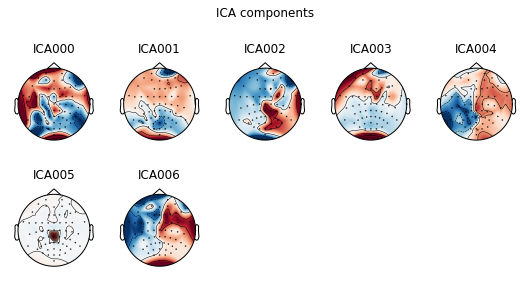

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


In [68]:
ica.plot_components(picks=range(7), inst=ds)

### Exclude blink related components etc

In [76]:
blink_components = [3, 5, 6]

ica.exclude = blink_components
ica.apply(raw)

Transforming to ICA space (7 components)
Zeroing out 3 ICA components


<RawBrainVision  |  e003b1.eeg, n_channels x n_times : 66 x 3246700 (3246.7 sec), ~1.60 GB, data loaded>

### Find events

This identifies triggers.

In [77]:
print("FINDING EVENTS")
events = mne.find_events(raw, stim_channel='STI 014', shortest_event=1)

FINDING EVENTS
1206 events found
Event IDs: [ 1  2  3  4  5  6  7  8 20 21 25]


### Create epochs

Here we split the continuous data into epochs. Stimulus triggers are from 2 to the number of stimuli * 2 with a step of 2 (this is because sending odd numbers also triggers shocks in the actual task). Code 99 is used for null trials (only used in the localiser). We don't reject any trials because we want to decide on rejections later.

We're only selecting the planning and rest periods from the task here as these are the periods we'll be looking for replay during.

In [78]:
events[510:, 2] += 30

In [79]:
print("EPOCHING")

# reject = dict(eeg=180e-6)
reject = None

# Get event names
# Event numbers for the localiser are even numbers from 2 up to 2 * the number of stimuli
localiser_event_names = dict([('stimulus_{0}'.format(i), i) for i in list(range(1, n_stim + 1, 1)) + []])

# We get task event numbers from the task config file
with open('../MEG/task/replay_task_settings.yaml', 'rb') as f:
    task_config = yaml.load(f)
task_event_names = task_config['triggers']
task_event_names = dict([(k, int(v / 4) + 30) for k, v in task_event_names.items()])

# Create the epoch objects
localiser_epochs = mne.Epochs(raw, events[np.isin(events[:, 2], list(localiser_event_names.values()))], tmin=-0.1, tmax=0.5, preload=True, event_id=localiser_event_names, reject=reject)

task_epochs = mne.Epochs(raw, events[np.isin(events[:, 2], list(task_event_names.values()))], 
                         tmin=0, tmax=np.max([task_config['MEG_durations']['start_duration'], task_config['MEG_durations']['rest_duration']]), 
                         preload=True, event_id={k: task_event_names[k] for k in ('planning', 'rest', 'outcome_only_warning')}, reject=None)

EPOCHING
510 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 510 events and 601 original time points ...
7 bad epochs dropped
200 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 200 events and 6001 original time points ...
2 bad epochs dropped


In [80]:
print("LOCALISER EVENTS")

for k, v in localiser_event_names.items():
    print("Number of {0} events = {1}".format(k, np.sum(events[:, 2] == v)))
    
print("TASK EVENTS")

for k, v in task_event_names.items():
    print("Number of {0} events = {1}".format(k, np.sum(events[:, 2] == v)))

LOCALISER EVENTS
Number of stimulus_1 events = 71
Number of stimulus_2 events = 71
Number of stimulus_3 events = 57
Number of stimulus_4 events = 81
Number of stimulus_5 events = 70
Number of stimulus_6 events = 78
Number of stimulus_7 events = 82
TASK EVENTS
Number of rest events = 100
Number of planning events = 74
Number of move_entering events = 74
Number of outcome_only_outcome events = 26
Number of outcome_only_warning events = 26
Number of shock_outcome events = 53
Number of no_shock_outcome events = 47
Number of state_trigger_start events = 74


### Check the events look right

First, we should have 600 localiser events (or thereabouts - a couple of runs got cut short by a trial or two)

In [81]:
assert len(localiser_epochs) > 500, 'Unexpected number of localiser trials, found {0}, expected 600'.format(len(localiser_epochs))

### Downsample

Resampling to 100hz.

In [82]:
# del raw  # Delete the raw data variable to save memory

print("DOWNSAMPLING")
print('Original sampling rate: {0} Hz'.format(localiser_epochs.info['sfreq']))
localiser_epochs = localiser_epochs.copy().resample(100, npad='auto')
task_epochs = task_epochs.copy().resample(100, npad='auto')

DOWNSAMPLING
Original sampling rate: 1000.0 Hz


## Run autoreject

In [93]:
from autoreject import (AutoReject, set_matplotlib_defaults)
n_interpolates = np.array([1, 4, 32])
consensus_percs = np.linspace(0, 1.0, 11)
ar = AutoReject(n_interpolates, consensus_percs, 
                thresh_method='random_search', random_state=100, n_jobs=4)

task_epochs.info['bads'] = []
localiser_epochs.info['bads'] = []
task_epochs_clean = ar.fit_transform(task_epochs)
localiser_epochs_clean = ar.fit_transform(localiser_epochs)

Running autoreject on ch_type=eeg
[............................................................] 100.00% Creating augmented epochs /   Computing thresholds ...
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
Memmapping (shape=(396, 600), dtype=float64) to new file C:\Users\Toby\AppData\Local\Temp\joblib_memmapping_folder_16748_675829236\16748-2527685891128-258d90b4b1d144859186ad2107e74120.pkl
Memmapping (shape=(396, 600), dtype=float64) to new file C:\Users\Toby\AppData\Local\Temp\joblib_memmapping_folder_16748_675829236\16748-2527685891128-25c441f203324e27a9fec8f1624cbc76.pkl
Memmapping (shape=(396, 600), dtype=float64) to new file C:\Users\Toby\AppData\Local\Temp\joblib_memmapping_folder_16748_675829236\16748-2527685891128-a1d5376eb5ca47e1936ab6734f3680e6.pkl
Memmapping (shape=(396, 600), dtype=float64) to new file C:\Users\Toby\AppData\Local\Temp\joblib_memmapping_folder_16748_675829236\16748-2527685891128-f0157e9cdc1d4189845511b1c2b42136.pkl
Memmapping (s

C:\Users\Toby\Anaconda2\envs\mne\lib\site-packages\autoreject\autoreject.py:1030: UserWarning:

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.



In [96]:
task_epochs_clean.plot(n_epochs=5);

Dropped 0 epochs
Channels marked as bad: []


### Save the epoched data

In [94]:
localiser_epochs_clean.save(os.path.join(output_dir, 'preprocessing/localiser', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format(session_id))
task_epochs_clean.save(os.path.join(output_dir, 'preprocessing/task', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-task_proc_ICA-epo.fif.gz').format(session_id))

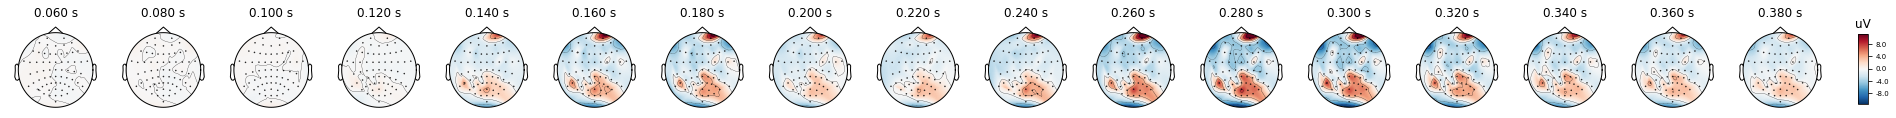

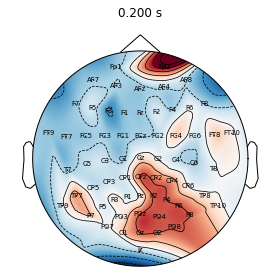

In [101]:
times = np.arange(0.06, 0.4, 0.02)
evoked = localiser_epochs.average()
evoked.plot_topomap(times, ch_type='eeg')
evoked.plot_topomap(0.2, ch_type='eeg', show_names=True, colorbar=False, size=3, res=128);

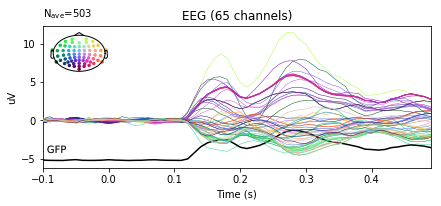

In [99]:
evoked = localiser_epochs.average()
evoked.plot(spatial_colors=True, gfp=True, time_unit='s');

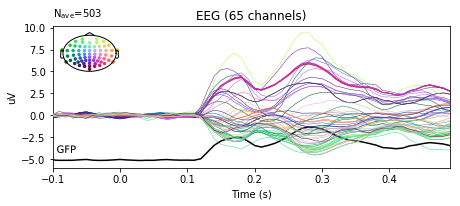

In [100]:
evoked = localiser_epochs_clean.average()
evoked.plot(spatial_colors=True, gfp=True, time_unit='s');